# MNIST-Neural Network-Batch Normalization and Weight Decay

In [1]:
# coding: utf-8
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import math

sys.path.append(os.pardir)
from common.mnist import *
from common.networks import *

## Multilayer Neural Network Model (Two Hidden Layers) and Learing/Validation

### Initializers 

In [2]:
# coding: utf-8
import numpy as np

class Initializer:
    def __init__(self, params, params_size_list, use_batch_normalization=False):
        self.params = params
        self.params_size_list = params_size_list
        self.use_batch_normalization = use_batch_normalization

    def initialize_params(self):
        pass

    def get_params(self):
        return self.params


class Zero_Initializer(Initializer):
    def initialize_params(self, use_batch_normalization):
        for idx in range(1, len(self.params_size_list)):
            self.params['W' + str(idx)] = np.zeros(self.params_size_list[idx - 1], self.params_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(self.params_size_list[idx])
            if self.use_batch_normalization and idx < len(self.params_size_list) - 1:
                self.params['gamma' + str(idx)] = np.zeros(self.params_size_list[idx])
                self.params['beta' + str(idx)] = np.zeros(self.params_size_list[idx])

class N1_Initializer(Initializer):
    def initialize_params(self):
        for idx in range(1, len(self.params_size_list)):
            self.params['W' + str(idx)] = np.random.randn(self.params_size_list[idx - 1], self.params_size_list[idx])
            self.params['b' + str(idx)] = np.random.randn(self.params_size_list[idx])
            if self.use_batch_normalization and idx < len(self.params_size_list) - 1:
                self.params['gamma' + str(idx)] = np.random.randn(self.params_size_list[idx])
                self.params['beta' + str(idx)] = np.random.randn(self.params_size_list[idx])

class N2_Initializer(Initializer):
    def initialize_params(self):
        for idx in range(1, len(self.params_size_list)):
            self.params['W' + str(idx)] = np.random.randn(self.params_size_list[idx - 1], self.params_size_list[idx]) * 0.01
            self.params['b' + str(idx)] = np.random.randn(self.params_size_list[idx]) * 0.01
            if self.use_batch_normalization and idx < len(self.params_size_list) - 1:
                self.params['gamma' + str(idx)] = np.random.randn(self.params_size_list[idx]) * 0.01
                self.params['beta' + str(idx)] = np.random.randn(self.params_size_list[idx]) * 0.01

class Xavier_Initializer(Initializer):
    def initialize_params(self):
        for idx in range(1, len(self.params_size_list)):
            self.params['W' + str(idx)] = np.random.randn(self.params_size_list[idx - 1], self.params_size_list[idx]) / np.sqrt(self.params_size_list[idx - 1])
            self.params['b' + str(idx)] = np.random.randn(self.params_size_list[idx]) / np.sqrt(self.params_size_list[idx - 1])
            if self.use_batch_normalization and idx < len(self.params_size_list) - 1:
                self.params['gamma' + str(idx)] = np.random.randn(self.params_size_list[idx]) / np.sqrt(self.params_size_list[idx - 1])
                self.params['beta' + str(idx)] = np.random.randn(self.params_size_list[idx]) / np.sqrt(self.params_size_list[idx - 1])


class He_Initializer(Initializer):
    def initialize_params(self):
        for idx in range(1, len(self.params_size_list)):
            self.params['W' + str(idx)] = np.random.randn(self.params_size_list[idx - 1], self.params_size_list[idx]) * np.sqrt(2) / np.sqrt(self.params_size_list[idx - 1])
            self.params['b' + str(idx)] = np.random.randn(self.params_size_list[idx]) * np.sqrt(2) / np.sqrt(self.params_size_list[idx - 1])
            if self.use_batch_normalization and idx < len(self.params_size_list) - 1:
                self.params['gamma' + str(idx)] = np.random.randn(self.params_size_list[idx]) * np.sqrt(2) / np.sqrt(self.params_size_list[idx - 1])
                self.params['beta' + str(idx)] = np.random.randn(self.params_size_list[idx]) * np.sqrt(2) / np.sqrt(self.params_size_list[idx - 1])

### New Layer - Batch Normalization

In [3]:
class BatchNormalization:
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None

        self.running_mean = running_mean
        self.running_var = running_var  
        
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, is_train=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, is_train)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, is_train):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if is_train:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

In [4]:
activation_layers = {
    'Sigmoid': Sigmoid,
    'ReLU': ReLU
}

optimizers = {
    "SGD": SGD,
    "Momentum": Momentum,
    "Nesterov": Nesterov,
    "AdaGrad": AdaGrad,
    "RMSprop": RMSprop,
    "Adam": Adam
}

initializers = {
    'Zero': Zero_Initializer,
    'N1': N1_Initializer,
    'N2': N2_Initializer, # We will use this as a new initializer for supporting Batch Normalization
    'Xavier': Xavier_Initializer,
    'He': He_Initializer
}

### Multi Layer Model Class

In [5]:
class MultiLayerNetExtended(MultiLayerNet):
    def __init__(self, input_size, hidden_size_list, output_size, activation='ReLU', initializer='N2', 
                 optimizer='AdaGrad', learning_rate=0.01, 
                 use_batch_normalization=False, 
                 use_weight_decay=False, weight_decay_lambda=0.0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        
        self.use_batch_normalization = use_batch_normalization

        self.use_weight_decay = use_weight_decay
        self.weight_decay_lambda = weight_decay_lambda
            
        # Weight Initialization
        self.params = {}
        self.weight_initialization(initializer)
        
        # Layering
        self.layers = OrderedDict()
        self.last_layer = None
        self.layering(activation)

        # Optimization Method
        self.optimizer = optimizers[optimizer](lr=learning_rate)
    
    def weight_initialization(self, initializer):
        params_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        initializer_obj = initializers[initializer](self.params, 
                                                    params_size_list, 
                                                    self.use_batch_normalization)
        initializer_obj.initialize_params();
        
    def layering(self, activation):
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            if self.use_batch_normalization:
                self.layers['Batch_Normalization' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], 
                                                                                   self.params['beta' + str(idx)])
            self.layers['Activation' + str(idx)] = activation_layers[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithCrossEntropyLoss()  

    def predict(self, x, is_train=False):
        for key, layer in self.layers.items():
            if "BatchNorm" in key:
                x = layer.forward(x, is_train)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t, is_train=False):
        y = self.predict(x, is_train)

        if self.use_weight_decay:
            weight_decay = 0.0
            for idx in range(1, self.hidden_layer_num + 2):
                W = self.params['W' + str(idx)]
                weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
            return self.last_layer.forward(y, t) + weight_decay
        else:
            return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x, is_train=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy        

    def backpropagation_gradient(self, x, t):
        # forward
        self.loss(x, t, is_train=True)

        # backward
        din = 1
        din = self.last_layer.backward(din)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            din = layer.backward(din)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            if self.use_weight_decay:
                grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            else:
                grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batch_normalization and idx <= self.hidden_layer_num:
                grads['gamma' + str(idx)] = self.layers['Batch_Normalization' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['Batch_Normalization' + str(idx)].dbeta
                
        return grads

    def learning(self, x_batch, t_batch):
        grads = self.backpropagation_gradient(x_batch, t_batch)
        self.optimizer.update(self.params, grads)

### Training and Evaluation

In [6]:
data = mnist_data("/Users/yhhan/git/aiclass/0.Professor/data/MNIST_data/.")
(img_train, label_train), (img_validation, label_validation), (img_test, label_test) = data.load_mnist(flatten=True, normalize=True, one_hot_label=True)

input_size=784
hidden_layer1_size=128
hidden_layer2_size=128
output_size=10

num_epochs = 50
train_size = img_train.shape[0]
batch_size = 1000
learning_rate = 0.1

markers = {"N2, AdaGrad, No_Batch_Norm, lambda=0.0": "+", 
           "N2, AdaGrad, Batch_Norm, lambda=0.0": "*", 
           "N2, AdaGrad, Batch_Norm, lambda=0.1": "o",
           "He, AdaGrad, No_Batch_Norm, lambda=0.0": "x", 
           "He, AdaGrad, Batch_Norm, lambda=0.0": "h", 
           "He, AdaGrad, Batch_Norm, lambda=0.1": "H"}

networks = {}
train_errors = {}
validation_errors = {}
test_accuracy_values = {}
max_test_accuracy_epoch = {}
max_test_accuracy_value = {}

for key in markers.keys():
    if key == "N2, AdaGrad, No_Batch_Norm, lambda=0.0":
        networks[key] = MultiLayerNetExtended(input_size, [hidden_layer1_size, hidden_layer2_size], output_size, 
                                activation='ReLU', 
                                initializer='N2',
                                optimizer='AdaGrad', learning_rate=learning_rate,
                                use_batch_normalization=False, 
                                use_weight_decay=False, weight_decay_lambda=0.0)
    elif key == "N2, AdaGrad, Batch_Norm, lambda=0.0":
        networks[key] = MultiLayerNetExtended(input_size, [hidden_layer1_size, hidden_layer2_size], output_size, 
                                activation='ReLU', 
                                initializer='N2',
                                optimizer='AdaGrad', learning_rate=learning_rate,
                                use_batch_normalization=True,
                                use_weight_decay=False, weight_decay_lambda=0.0)
    elif key == "N2, AdaGrad, Batch_Norm, lambda=0.1":
        networks[key] = MultiLayerNetExtended(input_size, [hidden_layer1_size, hidden_layer2_size], output_size, 
                                activation='ReLU', 
                                initializer='N2',
                                optimizer='AdaGrad', learning_rate=learning_rate,
                                use_batch_normalization=True,
                                use_weight_decay=True, weight_decay_lambda=0.1)        
    elif key == "He, AdaGrad, No_Batch_Norm, lambda=0.0":
        networks[key] = MultiLayerNetExtended(input_size, [hidden_layer1_size, hidden_layer2_size], output_size, 
                                activation='ReLU', 
                                initializer='He',
                                optimizer='AdaGrad', learning_rate=learning_rate,
                                use_batch_normalization=False,
                                use_weight_decay=False, weight_decay_lambda=0.0)
    elif key == "He, AdaGrad, Batch_Norm, lambda=0.0":
        networks[key] = MultiLayerNetExtended(input_size, [hidden_layer1_size, hidden_layer2_size], output_size, 
                                activation='ReLU', 
                                initializer='He',
                                optimizer='AdaGrad', learning_rate=learning_rate,
                                use_batch_normalization=True,
                                use_weight_decay=False, weight_decay_lambda=0.0)
    elif key == "He, AdaGrad, Batch_Norm, lambda=0.1":
        networks[key] = MultiLayerNetExtended(input_size, [hidden_layer1_size, hidden_layer2_size], output_size, 
                                activation='ReLU', 
                                initializer='He',
                                optimizer='AdaGrad', learning_rate=learning_rate,
                                use_batch_normalization=True,
                                use_weight_decay=True, weight_decay_lambda=0.1)        
        
    train_errors[key] = [] 
    validation_errors[key] = []
    test_accuracy_values[key] = []
    max_test_accuracy_epoch[key] = 0
    max_test_accuracy_value[key] = 0.0

In [7]:
epoch_list = []

num_batch = math.ceil(train_size / batch_size)

for i in range(num_epochs):
    epoch_list.append(i)
    for key in markers.keys():
        for k in range(num_batch):
            x_batch = img_train[k * batch_size : k * batch_size + batch_size]
            t_batch = label_train[k * batch_size : k * batch_size + batch_size]
            networks[key].learning(x_batch, t_batch)

        train_loss = networks[key].loss(x_batch, t_batch, is_train=True)
        train_errors[key].append(train_loss)

        validation_loss = networks[key].loss(img_validation, label_validation, is_train=False)
        validation_errors[key].append(validation_loss)    

        test_accuracy = networks[key].accuracy(img_test, label_test)
        test_accuracy_values[key].append(test_accuracy)
        if test_accuracy > max_test_accuracy_value[key]:
            max_test_accuracy_epoch[key] = i
            max_test_accuracy_value[key] = test_accuracy
        print("{0:38s}-Epoch:{1:3d}, Train Err.:{2:7.5f}, Validation Err.:{3:7.5f}, Test Accuracy:{4:7.5f}, Max Test Accuracy:{5:7.5f}".format(
            key,
            i,
            train_loss,
            validation_loss,
            test_accuracy,
            max_test_accuracy_value[key]
        ))
    print()    

N2, AdaGrad, No_Batch_Norm, lambda=0.0-Epoch:  0, Train Err.:0.29420, Validation Err.:0.27180, Test Accuracy:0.90270, Max Test Accuracy:0.90270
N2, AdaGrad, Batch_Norm, lambda=0.0   -Epoch:  0, Train Err.:0.09101, Validation Err.:0.11990, Test Accuracy:0.95630, Max Test Accuracy:0.95630
N2, AdaGrad, Batch_Norm, lambda=0.1   -Epoch:  0, Train Err.:1.17575, Validation Err.:1.21322, Test Accuracy:0.77510, Max Test Accuracy:0.77510
He, AdaGrad, No_Batch_Norm, lambda=0.0-Epoch:  0, Train Err.:0.24563, Validation Err.:0.21871, Test Accuracy:0.91570, Max Test Accuracy:0.91570
He, AdaGrad, Batch_Norm, lambda=0.0   -Epoch:  0, Train Err.:0.07612, Validation Err.:0.11275, Test Accuracy:0.95690, Max Test Accuracy:0.95690
He, AdaGrad, Batch_Norm, lambda=0.1   -Epoch:  0, Train Err.:1.06066, Validation Err.:1.08043, Test Accuracy:0.81700, Max Test Accuracy:0.81700

N2, AdaGrad, No_Batch_Norm, lambda=0.0-Epoch:  1, Train Err.:0.18584, Validation Err.:0.19378, Test Accuracy:0.93030, Max Test Accuracy

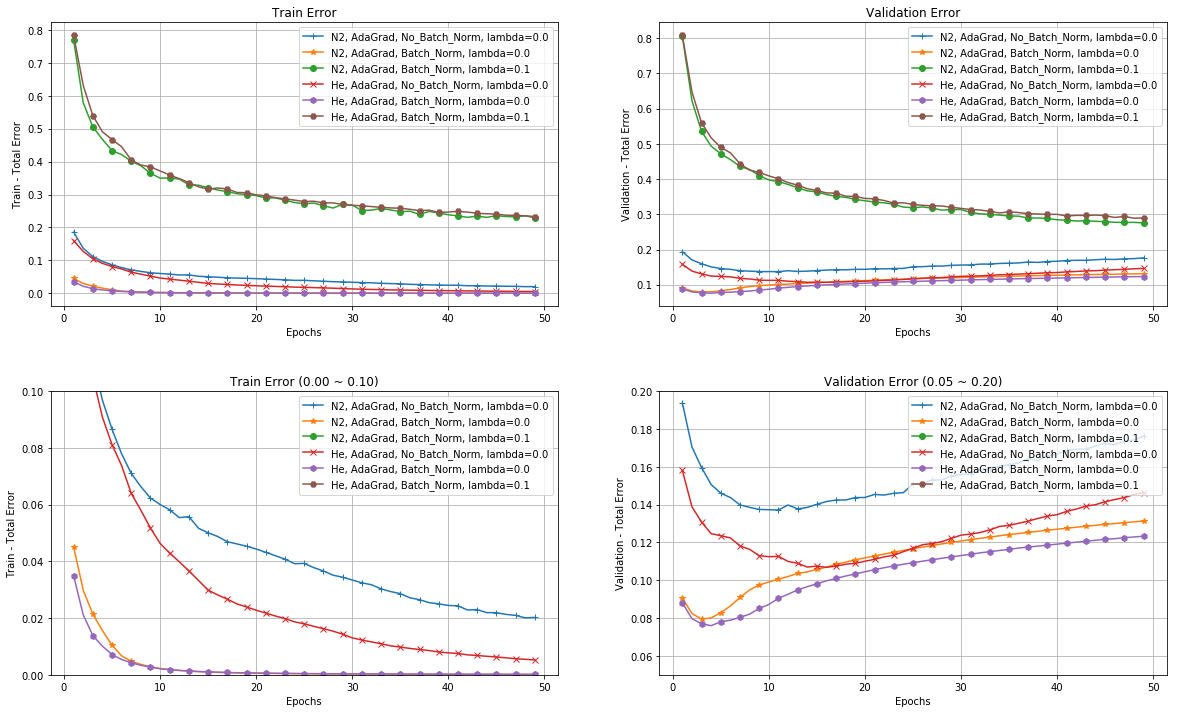

In [11]:
f, axarr = plt.subplots(2, 2, figsize=(20, 12))
for key in markers.keys():
    axarr[0, 0].plot(epoch_list[1:], train_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[0, 0].set_ylabel('Train - Total Error')
axarr[0, 0].set_xlabel('Epochs')
axarr[0, 0].grid(True)
axarr[0, 0].set_title('Train Error')
axarr[0, 0].legend(loc='upper right')

for key in markers.keys():
    axarr[0, 1].plot(epoch_list[1:], validation_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[0, 1].set_ylabel('Validation - Total Error')
axarr[0, 1].set_xlabel('Epochs')
axarr[0, 1].grid(True)
axarr[0, 1].set_title('Validation Error')
axarr[0, 1].legend(loc='upper right')

for key in markers.keys():
    axarr[1, 0].plot(epoch_list[1:], train_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[1, 0].set_ylabel('Train - Total Error')
axarr[1, 0].set_xlabel('Epochs')
axarr[1, 0].grid(True)
axarr[1, 0].set_ylim(0, 0.1)
axarr[1, 0].set_title('Train Error (0.00 ~ 0.10)')
axarr[1, 0].legend(loc='upper right')

for key in markers.keys():
    axarr[1, 1].plot(epoch_list[1:], validation_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[1, 1].set_ylabel('Validation - Total Error')
axarr[1, 1].set_xlabel('Epochs')
axarr[1, 1].grid(True)
axarr[1, 1].set_ylim(0.05, 0.2)
axarr[1, 1].set_title('Validation Error (0.05 ~ 0.20)')
axarr[1, 1].legend(loc='upper right')

f.subplots_adjust(hspace=0.3)

plt.show()

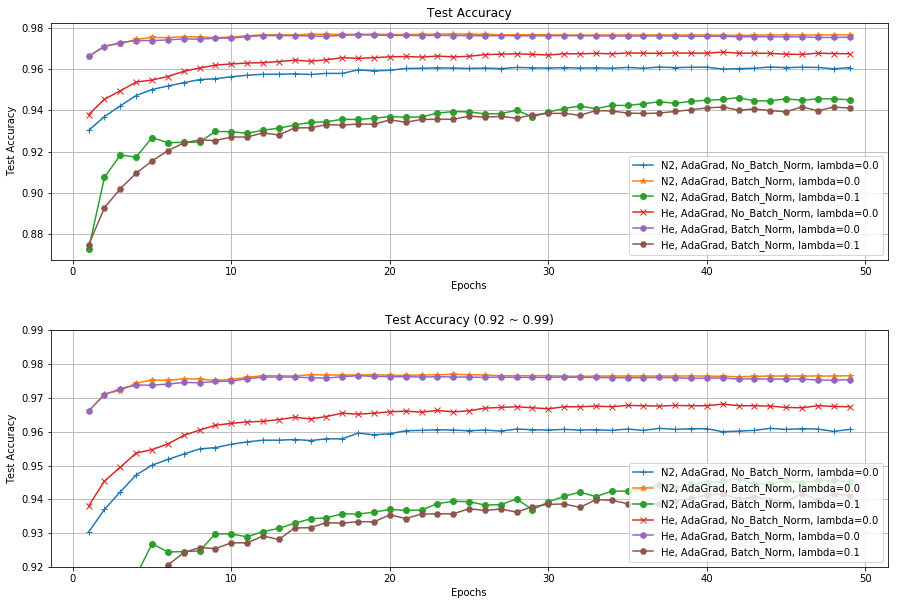

In [12]:
f, axarr = plt.subplots(2, 1, figsize=(15,10))
for key in markers.keys():
    axarr[0].plot(epoch_list[1:], test_accuracy_values[key][1:], marker=markers[key], markevery=1, label=key)
axarr[0].set_ylabel('Test Accuracy')
axarr[0].set_xlabel('Epochs')
axarr[0].grid(True)
axarr[0].set_title('Test Accuracy')
axarr[0].legend(loc='lower right')

for key in markers.keys():
    axarr[1].plot(epoch_list[1:], test_accuracy_values[key][1:], marker=markers[key], markevery=1, label=key)
axarr[1].set_ylabel('Test Accuracy')
axarr[1].set_xlabel('Epochs')
axarr[1].grid(True)
axarr[1].set_ylim(0.92, 0.99)
axarr[1].set_title('Test Accuracy (0.92 ~ 0.99)')
axarr[1].legend(loc='lower right')

f.subplots_adjust(hspace=0.3)
plt.show()

In [13]:
for key in markers.keys():
    print("{0:26s} - Epoch:{1:3d}, Max Test Accuracy: {2:7.5f}".format(key, max_test_accuracy_epoch[key], max_test_accuracy_value[key]))

N2, AdaGrad, No_Batch_Norm, lambda=0.0 - Epoch: 37, Max Test Accuracy: 0.96100
N2, AdaGrad, Batch_Norm, lambda=0.0 - Epoch: 24, Max Test Accuracy: 0.97700
N2, AdaGrad, Batch_Norm, lambda=0.1 - Epoch: 42, Max Test Accuracy: 0.94620
He, AdaGrad, No_Batch_Norm, lambda=0.0 - Epoch: 41, Max Test Accuracy: 0.96820
He, AdaGrad, Batch_Norm, lambda=0.0 - Epoch: 18, Max Test Accuracy: 0.97660
He, AdaGrad, Batch_Norm, lambda=0.1 - Epoch: 46, Max Test Accuracy: 0.94170
